<a href="https://colab.research.google.com/github/Ash-git-create/Data_Analytics_1_WiSe2024/blob/main/DA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the dataset from local machine
from google.colab import files
uploaded = files.upload()

Saving heart_with_issues.csv to heart_with_issues.csv


    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1  53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2   NaN    1   0     145.0  174.0    0        1      NaN      1      2.6   
3  61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
4  62.0    0   0     138.0  294.0    1        1    106.0      0      1.9   

   slope  ca  thal  target  
0      2   2     3       0  
1      0   0     3       0  
2      0   0     3       0  
3      2   1     3       0  
4      1   3     2       0  
Missing Values Before Imputation:
 age         59
sex          0
cp           0
trestbps    50
chol        60
fbs          0
restecg      0
thalach     50
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64
Missing Values After Imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
CNN Test Accuracy: 0.96
Random Forest Test Accuracy: 0.98


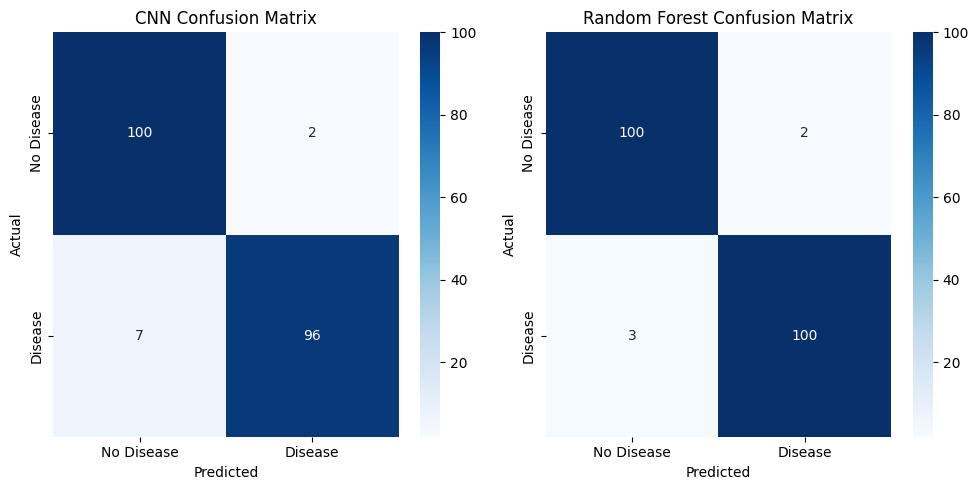


CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       102
         1.0       0.98      0.93      0.96       103

    accuracy                           0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       102
         1.0       0.98      0.97      0.98       103

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with issues
df = pd.read_csv('heart_with_issues.csv')
print(df.head())

# Identify out of range values and replace with NaN
df['age'] = df['age'].where((df['age'] > 0) & (df['age'] < 120), np.nan)
df['chol'] = df['chol'].where(df['chol'] > 0, np.nan)

# Before imputation
print("Missing Values Before Imputation:\n", df.isnull().sum())

# Impute missing values using KNN with 5 neighbours
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# After Imputation
print("Missing Values After Imputation:\n", df_imputed.isnull().sum())
print("Imputed Dataframe:\n", df_imputed.head())

# Normalize numeric features
scaler = StandardScaler()
numeric_features = df_imputed.select_dtypes(include=[np.number]).drop(columns=['target']).columns
df_imputed[numeric_features] = scaler.fit_transform(df_imputed[numeric_features])
print("Normalized Dataframe:\n", df_imputed.head())

# Splitting into target y
X = df_imputed.drop(columns=['target'])
y = df_imputed['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target to categorical for CNN
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

# 1. CNN Model
cnn_model = Sequential()
cnn_model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_cnn, epochs=120, batch_size=32, validation_split=0.2, verbose=0)

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Train the Random Forest model

# Predicting using CNN and Random Forest models
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_pred_rf = rf_model.predict(X_test)

# Evaluate CNN and Random Forest performance
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"CNN Test Accuracy: {cnn_accuracy:.2f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:.2f}")

# Confusion Matrix for CNN
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix for CNN
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot Confusion Matrix for Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Optional: Display Classification Reports
print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
